## Performance Evaluation of Weight Functions on Network Inversion ##
+ Figure 1   - Simulations on one pixel and Performance with one temporal decorrelation setting
+ Figure S2  - Performance with different temporal decorrelation settings
+ Figure S12 - Sampling of decorrelation noise based on phase PDF
+ Figure S13 - Time-series configuration for simulation.

In [1]:
%matplotlib inline
import os
import sys
import numpy as np
from matplotlib import pyplot as plt, ticker
from mintpy.defaults.plot import *
from mintpy.utils import ptime, utils as ut, network as pnet, plot as pp
from mintpy.objects import timeseries, ifgramStack, sensor
import mintpy.simulation as psim
import mintpy.ifgram_inversion as ifginv

work_dir = os.path.expanduser('~/Documents/Paper/2019_MintPy/Notebooks/sim_weightFunc')
os.chdir(work_dir)
print('Go to directory: '+work_dir)
sensor_name = sensor.project_name2sensor_name(os.path.join(work_dir, 'AlcedoSenDT128'))[0]

weight_functions = ['Uniform', 'Coherence', 'Inv Variance', 'Fisher info']

# Time-series Setup
ts_file = os.path.expanduser('~/insarlab/Galapagos/AlcedoSenDT128/mintpy/timeseries.h5')
ts_obj = timeseries(ts_file)
ts_obj.open()
ts_obj.save2bl_list_file(out_file='bl_list.txt')
# temporal baseline
tbase = np.array(ts_obj.tbase)
tbase_diff = np.diff(np.array(tbase, dtype=np.float32) / 365.25).reshape(-1, 1)
ts_sim = psim.sim_variable_timeseries(tbase, display=False)

date_list = ts_obj.dateList
dates, datevector = ptime.date_list2vector(date_list)

inc_angle = ut.incidence_angle(ts_obj.metadata, dimension=0, print_msg=False)
phase2range = -1*float(ts_obj.metadata['WAVELENGTH'])/(4.*np.pi)

# Network Setup
num_conn = 10
date12_list = pnet.select_pairs_sequential(ts_obj.dateList, num_connection=num_conn, date12_format='YYYYMMDD_YYYYMMDD')
stack_obj = ifgramStack(os.path.join(work_dir, 'AlcedoSenDT128/ifgramStack.h5'))
A, B = stack_obj.get_design_matrix4timeseries(date12_list=date12_list)
print('number of ifgrams: {}'.format(len(date12_list)))

## Decorrelation Noise Setup
coh_resid, decor_time = 0.0, 200  # 0.0, 50; 0.1, 50; 0.0, 200; 0.2, 200; 0.4, 200
num_sample = 10000
L_max = 50
out_file = 'rmsVT{:.0f}R{:.1f}L{:d}'.format(decor_time, coh_resid, L_max)
print('output file base: '+out_file)
print('Done.')

Go to directory: /Users/yunjunz/Documents/Paper/2019_MintPy/Notebooks/sim_weightFunc
open timeseries file: timeseries.h5
write baseline list info to file: bl_list.txt
number of ifgrams: 925
output file base: rmsVT200R0.0L50
Done.


save figure to file /Users/yunjunz/Documents/Paper/2019_MintPy/Notebook/sim_weightFunc/sim_coh_pha_mat.png


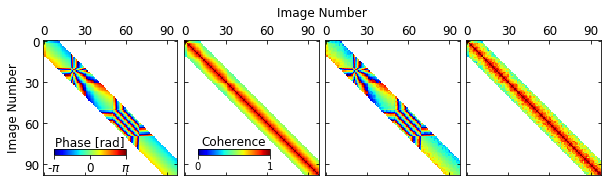

In [2]:
## (a-d) - Simulated coherence and coherence estimation / Noise-free and noisy phase

## Data prepare
# simulate network of interferometric phase and coherence
L = 3 * 9
ifgram_est, coh_est, ifg_sim, coh_sim = psim.simulate_network(ts_sim, date12_list, decor_time, coh_resid,
                                                              L=L, num_sample=num_sample,
                                                              baseline_file='bl_list.txt',
                                                              sensor_name=sensor_name,
                                                              inc_angle=inc_angle)
ifg_sim = ut.wrap(ifg_sim)
ifg_est = ut.wrap(ifgram_est[:,0])
# convert to matrix format for display
coh_sim_mat = pnet.coherence_matrix(date12_list, coh_sim, diag_value=1.)
coh_est_mat = pnet.coherence_matrix(date12_list, coh_est, diag_value=1.)
ifg_sim_mat = pnet.coherence_matrix(date12_list, ifg_sim)
ifg_est_mat = pnet.coherence_matrix(date12_list, ifg_est)
# skew symmetric nature of phase
ifg_sim_mat = -1 * np.triu(ifg_sim_mat, 1) + np.tril(ifg_sim_mat, -1)
ifg_est_mat = -1 * np.triu(ifg_est_mat, 1) + np.tril(ifg_est_mat, -1)

## Plot
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=[10, 2.5], sharey=True)
im_cor = axs[1].imshow(coh_sim_mat, vmin=0, vmax=1, cmap='jet')
im_cor = axs[3].imshow(coh_est_mat, vmin=0, vmax=1, cmap='jet')
im_ifg = axs[0].imshow(ifg_sim_mat, vmin=-np.pi, vmax=np.pi, cmap='jet')
im_ifg = axs[2].imshow(ifg_est_mat, vmin=-np.pi, vmax=np.pi, cmap='jet')
# axis format
for ax in axs:
    ax.xaxis.tick_top()
    ax.xaxis.set_major_locator(ticker.MultipleLocator(30))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(30))
    ax.tick_params(which='both', direction='in', labelsize=font_size, bottom=True, top=True, left=True, right=True)
axs[0].set_ylabel('Image Number', fontsize=font_size)
pp.set_shared_xlabel(axs, 'Image Number', labelpad=0.2, font_size=12, position='top')
fig.subplots_adjust(wspace=0.05)
# colorbars
cax = fig.add_axes([0.34, 0.24, 0.1, 0.03])
cbar = plt.colorbar(im_cor, cax=cax, ticks=[0, 1], orientation='horizontal')
cbar.set_label('Coherence', fontsize=font_size)
cbar.ax.xaxis.set_label_position('top') 

cax = fig.add_axes([0.14, 0.24, 0.1, 0.03])
cbar = plt.colorbar(im_ifg, cax=cax, ticks=[-np.pi, 0, np.pi], orientation='horizontal')
cbar.ax.set_xticklabels([r'-$\pi$', '0', r'$\pi$'], fontsize=font_size)
cbar.set_label('Phase [rad]', fontsize=font_size)
cbar.ax.xaxis.set_label_position('top')

## output
out_file = os.path.join(os.getcwd(), 'sim_coh_pha_mat.png')
#fig.savefig(out_file, bbox_inches='tight', transparent=True, dpi=fig_dpi)
print('save figure to file', out_file)
plt.show()

In [3]:
## Run Data for Figure 1 (e-f) - Get RMSE of estimated Time-series from inversion with different weight functions
def get_network_inversion_rms(ifgram, coh_data, L, min_norm_velocity=True, print_msg=True):
    """Get inversion RMS from truth for different weight functions"""
    num_func = len(weight_functions)
    rms = np.zeros(num_func, np.float32)
    for i in range(num_func):
        weight_func = weight_functions[i]
        weight = ifginv.coherence2weight(coh_data, weight_func=weight_func, L=L, print_msg=False)
        if weight is not None:
            weight = np.sqrt(weight)
        ts_inv = ifginv.estimate_timeseries(A, B, tbase_diff, ifgram, weight_sqrt=weight,
                                            min_norm_velocity=min_norm_velocity)[0]
        ts_diff = ts_inv - np.tile(ts_sim.reshape(-1,1), (1, num_sample)) / phase2range
        num_date = ts_diff.shape[0]
        rms[i] = np.mean(np.sqrt(np.sum(np.square(ts_diff), axis=0) / (num_date - 1)))
        #rms[i] = np.sqrt(np.mean(ts_diff**2))
        if print_msg:
            print('Weight function {} with RMS: {} radian'.format(weight_func, rms[i]))
    return rms, ts_inv

def get_rms_inv(decor_time, coh_resid, L_max=20, L_step=1, min_norm_velocity=True):
    #xx = np.arange(d_step, d_max+d_step, step=d_step, dtype=np.int16).reshape(-1, 1)
    xx = np.arange(L_step, L_max+L_step, step=L_step, dtype=np.int16).reshape(-1, 1)
    rms_inv = np.zeros((xx.size, len(weight_functions)), np.float32)
    print('residual coherence: {}'.format(coh_resid))
    print('decorrelation time: {} days'.format(decor_time))
    for i in range(xx.size):
        ifgram_est, coh_est = psim.simulate_network(ts_sim, date12_list, decor_time, coh_resid,
                                                    L=int(xx[i]), num_sample=num_sample,
                                                    baseline_file='bl_list.txt',
                                                    sensor_name=sensor_name,
                                                    inc_angle=inc_angle)[0:2]
        rms_inv[i, :] = get_network_inversion_rms(ifgram_est, coh_est, L=int(xx[i]),
                                                  min_norm_velocity=min_norm_velocity,
                                                  print_msg=False)[0]
        sys.stdout.write('\r{}/{}'.format(i+1, xx.size))
        sys.stdout.flush()
    print('')
    return xx, rms_inv

## calculate RMS of network inversion
for t_decor, c_resid in zip([50,  50,  200, 200, 200], 
                            [0.0, 0.1, 0.0, 0.2, 0.4]):
    out_file = 'rmsVT{:.0f}R{:.1f}L{:d}'.format(t_decor, c_resid, L_max)
    if not os.path.isfile('{}.npy'.format(out_file)):
        xx, rms_inv = get_rms_inv(decor_time=t_decor,
                                  coh_resid=c_resid,
                                  L_max=L_max)
        np.save(out_file, np.hstack((xx, rms_inv)))
print('Done.')

Done.


saved to rmsVT50R0.0L50.png
saved to rmsVT50R0.1L50.png
saved to rmsVT200R0.0L50.png
saved to rmsVT200R0.2L50.png
saved to rmsVT200R0.4L50.png


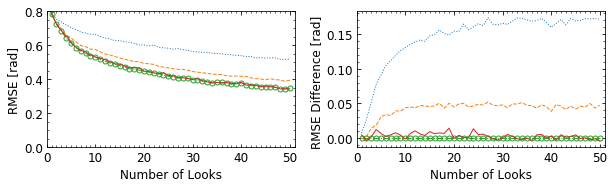

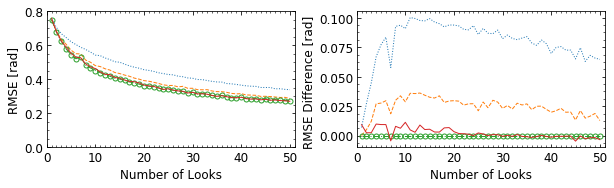

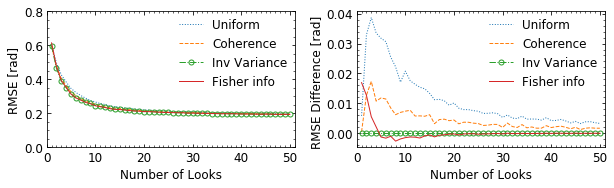

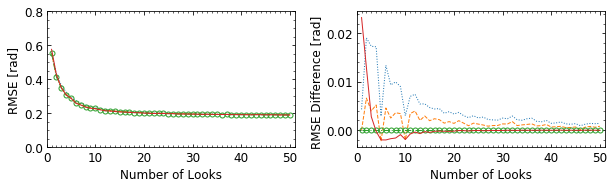

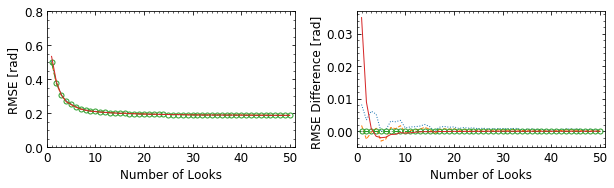

In [3]:
## (e-f) and S2 - RMSE of estimated time-series from inversion with different weight functions

def plot_rmse(xx, rms_inv):
    # plot
    marker_list = [':', '--', '-.o', '-']
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=[10, 2.5])
    for i in range(len(weight_functions)):
        rms = rms_inv[:, i]
        rms_diff = rms_inv[:, i] - rms_inv[:, -2]
        axs[0].plot(xx, rms,      marker_list[i], lw=1, ms=5, mfc='none', label=weight_functions[i])
        axs[1].plot(xx, rms_diff, marker_list[i], lw=1, ms=5, mfc='none', label=weight_functions[i])

    # axis format
    axs[0].set_ylim(bottom=0.)
    axs[0].set_ylim(top=0.8)
    axs[0].set_ylabel('RMSE [rad]', fontsize=font_size)
    axs[1].set_ylabel('RMSE Difference [rad] ', fontsize=font_size)
    for ax in axs:
        ax.set_xlabel('Number of Looks', fontsize=font_size)
        ax.set_xlim((0., np.max(xx)+1))
        ax.xaxis.set_minor_locator(ticker.AutoMinorLocator(10))
        ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())
        ax.tick_params(which='both', direction='in', labelsize=font_size, bottom=True, top=True, left=True, right=True)
        if out_file == 'rmsVT200R0.0L50':
            ax.legend(loc='best', ncol=1, fontsize=font_size, frameon=False, borderpad=0.1)
    fig.subplots_adjust(wspace=0.25)

    # save
    out_img = '{}.png'.format(out_file)
    #plt.savefig(out_img, bbox_inches='tight', transparent=True, dpi=fig_dpi)
    print('saved to', out_img)
    return out_img

## plot all figures
for t_decor, c_resid in zip([50,  50,  200, 200, 200], 
                            [0.0, 0.1, 0.0, 0.2, 0.4]):
    out_file = 'rmsVT{:.0f}R{:.1f}L{:d}'.format(t_decor, c_resid, L_max)
    # read data
    fcontent = np.load('{}.npy'.format(out_file))
    xx = fcontent[:, 0].reshape(-1, 1)
    rms_inv = fcontent[:, 1:]
    # plot
    plot_rmse(xx, rms_inv)
plt.show()

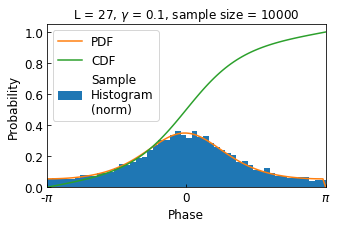

In [5]:
## Figure S12 - Generating Decorrelation Noise by Random Sampling with PDF determined by Coherence
x = psim.sample_decorrelation_phase(3*9, 0.1, size=int(num_sample), display=True)

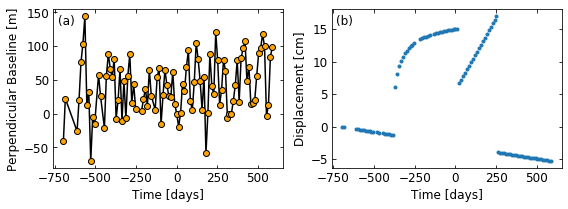

In [6]:
## Figure S13 - Time-series Setup
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=[8, 3])

axs[0].plot(tbase, ts_obj.pbase, '-ko', mfc='orange')
axs[0].set_ylabel('Perpendicular Baseline [m]', fontsize=font_size)

axs[1].plot(tbase, ts_sim * 100., '.')
axs[1].set_ylabel('Displacement [cm]', fontsize=font_size)

for ax, num in zip(axs, ['(a)', '(b)']):
    ax.set_xlabel('Time [days]', fontsize=font_size)
    ax.annotate(num, xy=(0.02, 0.9), color='k', xycoords='axes fraction', fontsize=font_size)
    ax.tick_params(which='both', direction='in', labelsize=font_size, bottom=True, top=True, left=True, right=True)
fig.tight_layout()

fig.savefig('timeseries_setup.jpg', bbox_inches='tight', transparent=True, dpi=fig_dpi)
plt.show()

In [ ]:
## Add insert axes
#from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset, inset_axes
#ax1 = inset_axes(ax, width='50%', height='45%', loc='upper right', borderpad=1.)  ## add insert rectangle
#for i in range(len(weight_functions)):
#    ax1.plot(xx.reshape(-1, 1), rms_inv[:, i], marker_list[i], lw=1, ms=5, mfc='none', label=weight_functions[i])
#ax1.set_xlim(0.8, 4.2)
#daoi = rms_inv[0:4,:]
#ymin1, ymax1 = np.min(daoi), np.max(daoi); ylen = ymax1 - ymin1
#ax1.set_ylim(ymin1-ylen*0.1, ymax1+ylen*0.1)
#ax1.xaxis.set_minor_locator(ticker.AutoMinorLocator(1))
#ax1.yaxis.set_minor_locator(ticker.AutoMinorLocator())
#ax1.tick_params(which='both', direction='in', labelsize=font_size, bottom=True, top=True, left=True, right=True)
#mark_inset(ax, ax1, loc1=2, loc2=3, fc="none", ec="0.5")